In [1]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
import json
from datetime import datetime, timedelta


try:
    # Data modeling schema classes (using Apply suffix)
    from cognite.client.data_classes.data_modeling import (
        DataModelApply, ViewApply, SpaceApply,
        NodeApply, EdgeApply, PropertyOptions,
        ContainerApply, ContainerProperty,
        MappedPropertyApply, InstanceApply,
        NodeOrEdgeData

    )
    # ID classes for referencing objects
    from cognite.client.data_classes.data_modeling.ids import (
        ContainerId, ViewId, DataModelId
    )
    from cognite.client.data_classes.data_modeling.data_types import (
        Text, Float64, Timestamp, Boolean, Int64
    )
    from cognite.client.data_classes.data_modeling.views import (
        ViewPropertyApply,
        ConnectionDefinitionApply
    )

    CDF_IMPORTS_AVAILABLE = True
    print("✅ Successfully imported data modeling classes for SDK v7.76")
    print("   Classes available: SpaceApply, ContainerApply, ViewApply, DataModelApply")
    print("   Instance classes: InstanceApply, NodeApply, EdgeApply")
except ImportError as e:
    print(f"❌ CDF SDK imports not available: {e}")
    print("Please upgrade cognite-sdk: pip install cognite-sdk --upgrade")
    CDF_IMPORTS_AVAILABLE = False


# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
except ImportError:
    print("⚠️  Matplotlib not available. Install with: pip install matplotlib")
    PLOTTING_AVAILABLE = False

✅ Successfully imported data modeling classes for SDK v7.76
   Classes available: SpaceApply, ContainerApply, ViewApply, DataModelApply
   Instance classes: InstanceApply, NodeApply, EdgeApply
✅ Matplotlib available for plotting


In [2]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python ../../test_connection.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run performance tests!")
    else:
        print("Connection test failed. Please check your credentials.")



✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev


C:\Users\JanIngeBergseth\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py:766: UserWarning: You are using version='7.76.1' of the SDK, however version='7.77.1' is available. To suppress this warning, either upgrade or do the following:
>>> from cognite.client.config import global_config
>>> global_config.disable_pypi_version_check = True
  _threading_Thread_run(self)


  Token is valid and accessible
Ready to run performance tests!


In [3]:
# Create Test Data Model Setup
def setup_test_data_model():
    """Create test space, containers, views, and data model for performance testing."""
    
    if client is None:
        print("❌ Client not available. Run client setup first.")
        return None, [], [], None
    
    print("🏗️ Setting up test data model...")
    timestamp = int(time.time())
    
    # 1. Create test space
    test_space_id = f"perf_test_space_{timestamp}"
    print(f"  Creating test space: {test_space_id}")
    
    try:
        test_space = SpaceApply(
            space=test_space_id,
            name="Performance Test Space",
            description="Space for data modeling performance tests"
        )
        client.data_modeling.spaces.apply([test_space])
        print(f"    ✅ Space created: {test_space_id}")
    except Exception as e:
        print(f"    ❌ Error creating space: {e}")
        return None, [], [], None
    
    # 2. Create test containers
    print("  Creating test containers...")
    containers = []
    container_ids = []
    
    # Asset container
    asset_container = ContainerApply(
        space=test_space_id,
        external_id="AssetContainer",
        name="Asset Container",
        properties={
            "name": ContainerProperty(type=Text()),
            "description": ContainerProperty(type=Text()),
            "status": ContainerProperty(type=Text()),
            "created_time": ContainerProperty(type=Timestamp()),
            "value": ContainerProperty(type=Float64())
        }
    )
    containers.append(asset_container)
    container_ids.append("AssetContainer")
    
    # Equipment container  
    equipment_container = ContainerApply(
        space=test_space_id,
        external_id="EquipmentContainer",
        name="Equipment Container",
        properties={
            "model": ContainerProperty(type=Text()),
            "manufacturer": ContainerProperty(type=Text()),
            "serial_number": ContainerProperty(type=Text()),
            "install_date": ContainerProperty(type=Timestamp()),
            "is_active": ContainerProperty(type=Boolean())
        }
    )
    containers.append(equipment_container)
    container_ids.append("EquipmentContainer")
    
    try:
        client.data_modeling.containers.apply(containers)
        print(f"    ✅ Created {len(containers)} containers")
    except Exception as e:
        print(f"    ❌ Error creating containers: {e}")
        return test_space_id, [], [], None
    
    # 3. Create test views
    print("  Creating test views...")
    views = []
    view_ids = []
    
    # Asset view
    asset_view = ViewApply(
        space=test_space_id,
        external_id="AssetView",
        name="Asset View",
        version="1",
        properties={
            "name": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="name"
            ),
            "description": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="description"
            ),
            "status": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="status"
            ),
            "created_time": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="created_time"
            ),
            "value": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="value"
            )
        }
    )
    views.append(asset_view)
    view_ids.append("AssetView")
    
    # Equipment view
    equipment_view = ViewApply(
        space=test_space_id,
        external_id="EquipmentView", 
        name="Equipment View",
        version="1",
        properties={
            "model": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="model"
            ),
            "manufacturer": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="manufacturer"
            ),
            "serial_number": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="serial_number"
            ),
            "install_date": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="install_date"
            ),
            "is_active": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="is_active"
            )
        }
    )
    views.append(equipment_view)
    view_ids.append("EquipmentView")
    
    try:
        client.data_modeling.views.apply(views)
        print(f"    ✅ Created {len(views)} views")
    except Exception as e:
        print(f"    ❌ Error creating views: {e}")
        return test_space_id, container_ids, [], None
    
    # 4. Create test data model
    print("  Creating test data model...")
    data_model_id = f"PerfTestDataModel_{timestamp}"
    
    try:
        data_model = DataModelApply(
            space=test_space_id,
            external_id=data_model_id,
            name="Performance Test Data Model",
            description="Data model for performance testing",
            version="1",
            views=[
                ViewId(space=test_space_id, external_id="AssetView", version="1"),
                ViewId(space=test_space_id, external_id="EquipmentView", version="1")
            ]
        )
        client.data_modeling.data_models.apply([data_model])
        print(f"    ✅ Created data model: {data_model_id}")
    except Exception as e:
        print(f"    ❌ Error creating data model: {e}")
        return test_space_id, container_ids, view_ids, None
    
    print(f"✅ Test data model setup complete!")
    print(f"   Space: {test_space_id}")
    print(f"   Containers: {container_ids}")
    print(f"   Views: {view_ids}")
    print(f"   Data model: {data_model_id}")
    
    return test_space_id, container_ids, view_ids, data_model_id

# Run the setup
test_space, test_containers, test_views, test_data_model = setup_test_data_model()


🏗️ Setting up test data model...
  Creating test space: perf_test_space_1753691059
    ✅ Space created: perf_test_space_1753691059
  Creating test containers...
    ✅ Created 2 containers
  Creating test views...
    ✅ Created 2 views
  Creating test data model...
    ✅ Created data model: PerfTestDataModel_1753691059
✅ Test data model setup complete!
   Space: perf_test_space_1753691059
   Containers: ['AssetContainer', 'EquipmentContainer']
   Views: ['AssetView', 'EquipmentView']
   Data model: PerfTestDataModel_1753691059


In [4]:
# Create Test Data Model Setup
def setup_test_data_model():
    """Create test space, containers, views, and data model for performance testing."""
    
    if client is None:
        print("❌ Client not available. Run client setup first.")
        return None, [], [], None
    
    print("🏗️ Setting up test data model...")
    timestamp = int(time.time())
    
    # 1. Create test space
    test_space_id = f"perf_test_space_{timestamp}"
    print(f"  Creating test space: {test_space_id}")
    
    try:
        test_space = SpaceApply(
            space=test_space_id,
            name="Performance Test Space",
            description="Space for data modeling performance tests"
        )
        client.data_modeling.spaces.apply([test_space])
        print(f"    ✅ Space created: {test_space_id}")
    except Exception as e:
        print(f"    ❌ Error creating space: {e}")
        return None, [], [], None
    
    # 2. Create test containers
    print("  Creating test containers...")
    containers = []
    container_ids = []
    
    # Asset container
    asset_container = ContainerApply(
        space=test_space_id,
        external_id="AssetContainer",
        name="Asset Container",
        properties={
            "name": ContainerProperty(type=Text()),
            "description": ContainerProperty(type=Text()),
            "status": ContainerProperty(type=Text()),
            "created_time": ContainerProperty(type=Timestamp()),
            "value": ContainerProperty(type=Float64())
        }
    )
    containers.append(asset_container)
    container_ids.append("AssetContainer")
    
    # Equipment container  
    equipment_container = ContainerApply(
        space=test_space_id,
        external_id="EquipmentContainer",
        name="Equipment Container",
        properties={
            "model": ContainerProperty(type=Text()),
            "manufacturer": ContainerProperty(type=Text()),
            "serial_number": ContainerProperty(type=Text()),
            "install_date": ContainerProperty(type=Timestamp()),
            "is_active": ContainerProperty(type=Boolean())
        }
    )
    containers.append(equipment_container)
    container_ids.append("EquipmentContainer")
    
    try:
        client.data_modeling.containers.apply(containers)
        print(f"    ✅ Created {len(containers)} containers")
    except Exception as e:
        print(f"    ❌ Error creating containers: {e}")
        return test_space_id, [], [], None
    
    # 3. Create test views
    print("  Creating test views...")
    views = []
    view_ids = []
    
    # Asset view
    asset_view = ViewApply(
        space=test_space_id,
        external_id="AssetView",
        name="Asset View",
        version="1",
        properties={
            "name": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="name"
            ),
            "description": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="description"
            ),
            "status": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="status"
            ),
            "created_time": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="created_time"
            ),
            "value": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="AssetContainer"),
                container_property_identifier="value"
            )
        }
    )
    views.append(asset_view)
    view_ids.append("AssetView")
    
    # Equipment view
    equipment_view = ViewApply(
        space=test_space_id,
        external_id="EquipmentView", 
        name="Equipment View",
        version="1",
        properties={
            "model": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="model"
            ),
            "manufacturer": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="manufacturer"
            ),
            "serial_number": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="serial_number"
            ),
            "install_date": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="install_date"
            ),
            "is_active": MappedPropertyApply(
                container=ContainerId(space=test_space_id, external_id="EquipmentContainer"),
                container_property_identifier="is_active"
            )
        }
    )
    views.append(equipment_view)
    view_ids.append("EquipmentView")
    
    try:
        client.data_modeling.views.apply(views)
        print(f"    ✅ Created {len(views)} views")
    except Exception as e:
        print(f"    ❌ Error creating views: {e}")
        return test_space_id, container_ids, [], None
    
    # 4. Create test data model
    print("  Creating test data model...")
    data_model_id = f"PerfTestDataModel_{timestamp}"
    
    try:
        data_model = DataModelApply(
            space=test_space_id,
            external_id=data_model_id,
            name="Performance Test Data Model",
            description="Data model for performance testing",
            version="1",
            views=[
                ViewId(space=test_space_id, external_id="AssetView", version="1"),
                ViewId(space=test_space_id, external_id="EquipmentView", version="1")
            ]
        )
        client.data_modeling.data_models.apply([data_model])
        print(f"    ✅ Created data model: {data_model_id}")
    except Exception as e:
        print(f"    ❌ Error creating data model: {e}")
        return test_space_id, container_ids, view_ids, None
    
    print(f"✅ Test data model setup complete!")
    print(f"   Space: {test_space_id}")
    print(f"   Containers: {container_ids}")
    print(f"   Views: {view_ids}")
    print(f"   Data model: {data_model_id}")
    
    return test_space_id, container_ids, view_ids, data_model_id

# Run the setup
test_space, test_containers, test_views, test_data_model = setup_test_data_model()


🏗️ Setting up test data model...
  Creating test space: perf_test_space_1753691062
    ✅ Space created: perf_test_space_1753691062
  Creating test containers...
    ✅ Created 2 containers
  Creating test views...
    ✅ Created 2 views
  Creating test data model...
    ✅ Created data model: PerfTestDataModel_1753691062
✅ Test data model setup complete!
   Space: perf_test_space_1753691062
   Containers: ['AssetContainer', 'EquipmentContainer']
   Views: ['AssetView', 'EquipmentView']
   Data model: PerfTestDataModel_1753691062


In [5]:
# Verify client and imports are available before proceeding
if client is None:
    raise RuntimeError(
        "CDF client is not available. Cannot proceed with performance tests.\n"
        "Please ensure your .env file is properly configured."
    )

# Verify CDF imports are available  
if not CDF_IMPORTS_AVAILABLE:
    raise RuntimeError(
        "CDF SDK imports are not available. Cannot proceed with data modeling tests.\n"
        "Please install cognite-sdk: pip install cognite-sdk --upgrade"
    )

print("🚀 Client verified. Initializing performance tracker...")

# Initialize performance tracker for data modeling operations
tracker = PerformanceTracker("data_modeling_operations")

print("✅ Ready to run data modeling performance tests!")
print(f"Available imports: SpaceApply, ContainerApply, ViewApply, DataModelApply")
print(f"Instance types: InstanceApply, NodeApply, EdgeApply")
print(f"SDK version: {client.version if hasattr(client, 'version') else 'Available'}")

# Show available spaces (if any)
try:
    spaces = client.data_modeling.spaces.list(limit=5)
    print(f"Available spaces: {len(spaces)} found")
    if spaces:
        for space in spaces:
            print(f"  - {space.space}")
except Exception as e:
    print(f"Note: Could not list spaces ({e})")

print("\n🎯 You can now proceed with data modeling performance tests!")

🚀 Client verified. Initializing performance tracker...
✅ Ready to run data modeling performance tests!
Available imports: SpaceApply, ContainerApply, ViewApply, DataModelApply
Instance types: InstanceApply, NodeApply, EdgeApply
SDK version: 7.76.1
Available spaces: 5 found
  - CommentInstanceSpace
  - IndustrialCanvasInstanceSpace
  - cognite-atlas-ai
  - perf_test_space_1752769143
  - perf_test_space_1752769147

🎯 You can now proceed with data modeling performance tests!


In [6]:
# Test 1: Instance Creation Performance
def test_instance_creation_performance(space_id, view_ids):
    """Test performance of creating instances in bulk."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🏭 Testing instance creation performance...")
    
    # Test different batch sizes for instance creation
    batch_sizes = [10, 50, 100, 250, 500]
    results = {}
    
    for batch_size in batch_sizes:
        print(f"  Testing batch size: {batch_size}")
        
        tracker = PerformanceTracker(f"instance_creation_{batch_size}")
        
        # Generate test instances for Asset view
        asset_view_id = view_ids[0] if view_ids else None
        if not asset_view_id:
            continue
            
        def create_instance_batch():
            instances_to_create = []
            timestamp = int(time.time() * 1000)
            
            for i in range(batch_size):
                if not asset_view_id:
                    raise ValueError("asset_view_id cannot be None")
                
                dt = datetime.fromtimestamp((timestamp + i) / 1000)
                created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds
                
                instance = NodeApply(
                    space=space_id,
                    external_id=f"asset_{timestamp}_{i}",
                    sources=[NodeOrEdgeData(
                        source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                        properties={
                            "name": f"Test Asset {i}",
                            "description": f"Performance test asset number {i}",
                            "status": "active" if i % 2 == 0 else "inactive",
                            "created_time": created_time_value,
                            "value": round(100 + i * 0.5, 2)
                        }
                    )]
                )
                instances_to_create.append(instance)
            
                # Apply instances
            if client is None:
                raise RuntimeError("CDF client is None - run client setup cell first")
            return client.data_modeling.instances.apply(instances_to_create)
        
        try:
            # Benchmark instance creation
            benchmark_results = benchmark_operation(create_instance_batch, iterations=5, warmup=1)
            results[batch_size] = benchmark_results
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Throughput: {batch_size / benchmark_results['mean_time']:.2f} instances/s")
            print(f"    Operations/sec: {benchmark_results['operations_per_second']:.2f}")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[batch_size] = None
    
    return results

# Initialize test variables if not available
test_space = globals().get('test_space', None)
test_views = globals().get('test_views', [])

# Run instance creation test
if test_space and test_views:
    creation_results = test_instance_creation_performance(test_space, test_views)
else:
    print("⚠️ Skipping instance creation test - no test space/views available")

🏭 Testing instance creation performance...
  Testing batch size: 10
    Mean time: 0.1187s
    Throughput: 84.23 instances/s
    Operations/sec: 8.42
  Testing batch size: 50
    Mean time: 0.1501s
    Throughput: 333.15 instances/s
    Operations/sec: 6.66
  Testing batch size: 100
    Mean time: 0.2223s
    Throughput: 449.82 instances/s
    Operations/sec: 4.50
  Testing batch size: 250
    Mean time: 0.3764s
    Throughput: 664.11 instances/s
    Operations/sec: 2.66
  Testing batch size: 500
    Mean time: 0.6349s
    Throughput: 787.47 instances/s
    Operations/sec: 1.57


In [7]:
# Test 2: Instance Query Performance
def test_instance_query_performance(space_id, view_ids):
    """Test performance of querying instances with different filters and limits."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🔍 Testing instance query performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    if not asset_view_id:
        return None
    
    # First, ensure we have some test instances
    print("  Creating sample instances for querying...")
    sample_instances = []
    timestamp = int(time.time() * 1000)
        
    for i in range(100):  # Create 100 sample instances

        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"query_test_asset_{timestamp}_{i}",
            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                properties={
                    "name": f"Query Test Asset {i}",
                    "description": f"Query performance test asset {i}",
                    "status": "active" if i % 3 == 0 else "inactive",
                    "created_time": created_time_value,
                    "value": round(50 + i * 1.5, 2)
                }
            )]
        )
        sample_instances.append(instance)
    
    try:
        client.data_modeling.instances.apply(sample_instances)
        print(f"    ✓ Created {len(sample_instances)} sample instances")
    except Exception as e:
        print(f"    ❌ Error creating sample instances: {e}")
        return None
    
    results = {}
    
    # Test 1: Query with different limits
    print("  Testing query limits...")
    limits = [10, 25, 50, 100, 200]
    
    for limit in limits:
        print(f"    Testing limit: {limit}")
        
        def query_with_limit():
            if client is None:
                raise RuntimeError("CDF client is None - run client setup cell first")
            return client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=space_id, external_id=asset_view_id, version="1")],
                limit=limit
            )
        
        try:
            benchmark_results = benchmark_operation(query_with_limit, iterations=10, warmup=2)
            results[f"limit_{limit}"] = benchmark_results
            
            # Get actual result count
            sample_result = query_with_limit()
            actual_count = len(sample_result) if sample_result else 0
            
            print(f"      Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"      Retrieved: {actual_count} instances")
            print(f"      Throughput: {actual_count / benchmark_results['mean_time']:.2f} instances/s")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
            results[f"limit_{limit}"] = None
    
    # Test 2: Query with filters
    print("  Testing filtered queries...")
    
    # Import correct filter classes
    from cognite.client.data_classes.filters import Equals, Range
    
    filter_tests = [
        {
            "name": "status_filter",
            "description": "Filter by status = 'active'",
            "filter": Equals(property=(space_id, f"{asset_view_id}/1", "status"), value="active")
        },
        {
            "name": "value_range", 
            "description": "Filter by value > 100",
            "filter": Range(property=(space_id, f"{asset_view_id}/1", "value"), gte=100)
        }
    ]
    
    for filter_test in filter_tests:
        print(f"    Testing {filter_test['name']}: {filter_test['description']}")
        
        def query_with_filter():
            if client is None:
                raise RuntimeError("CDF client is None - run client setup cell first")
            return client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=space_id, external_id=asset_view_id, version="1")],
                filter=filter_test["filter"],
                limit=100
            )
        
        try:
            benchmark_results = benchmark_operation(query_with_filter, iterations=5, warmup=1)
            results[filter_test["name"]] = benchmark_results
            
            # Get actual result count
            sample_result = query_with_filter()
            actual_count = len(sample_result) if sample_result else 0
            
            print(f"      Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"      Filtered results: {actual_count} instances")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
            results[filter_test["name"]] = None
    
    return results

# Run instance query test
if test_space and test_views:
    query_results = test_instance_query_performance(test_space, test_views)
else:
    print("⚠️ Skipping instance query test - no test space/views available")

🔍 Testing instance query performance...
  Creating sample instances for querying...
    ✓ Created 100 sample instances
  Testing query limits...
    Testing limit: 10
      Mean time: 0.0889s
      Retrieved: 10 instances
      Throughput: 112.48 instances/s
    Testing limit: 25
      Mean time: 0.0894s
      Retrieved: 25 instances
      Throughput: 279.74 instances/s
    Testing limit: 50
      Mean time: 0.0945s
      Retrieved: 50 instances
      Throughput: 528.92 instances/s
    Testing limit: 100
      Mean time: 0.0991s
      Retrieved: 100 instances
      Throughput: 1009.26 instances/s
    Testing limit: 200
      Mean time: 0.1226s
      Retrieved: 200 instances
      Throughput: 1631.35 instances/s
  Testing filtered queries...
    Testing status_filter: Filter by status = 'active'
      Mean time: 0.0952s
      Filtered results: 100 instances
    Testing value_range: Filter by value > 100
      Mean time: 0.1172s
      Filtered results: 100 instances


In [8]:
# Test 3: Instance Update Performance  
def test_instance_update_performance(space_id, view_ids):
    """Test performance of updating existing instances."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("✏️ Testing instance update performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    if not asset_view_id:
        return None
    
    # Create instances to update
    print("  Creating instances for update testing...")
    update_instances = []
    timestamp = int(time.time() * 1000)
    
    for i in range(50):  # Create 50 instances to update

        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"update_test_asset_{timestamp}_{i}",
            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                properties={
                    "name": f"Update Test Asset {i}",
                    "description": f"Original description {i}",
                    "status": "inactive",
                    "created_time": created_time_value,
                    "value": 100.0
                }
            )]
        )
        update_instances.append(instance)
    
    try:
        client.data_modeling.instances.apply(update_instances)
        print(f"    ✓ Created {len(update_instances)} instances for updating")
    except Exception as e:
        print(f"    ❌ Error creating instances: {e}")
        return None
    
    results = {}
    
    # Test different update batch sizes
    batch_sizes = [5, 10, 25, 50]
    
    for batch_size in batch_sizes:
        print(f"  Testing update batch size: {batch_size}")
        
        def update_instance_batch():
            # Select instances to update
            instances_to_update = []
            for i in range(min(batch_size, len(update_instances))):
                instance = update_instances[i]

                dt = datetime.fromtimestamp((timestamp + i) / 1000)
                created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

                # Create updated instance
                updated_instance = NodeApply(
                    space=space_id,
                    external_id=instance.external_id,
                    sources=[NodeOrEdgeData(
                        source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                        properties={
                            "name": f"Updated Asset {i}",
                            "description": f"Updated description {i} at {int(time.time())}",
                            "status": "active",
                            "created_time": created_time_value,
                            "value": 200.0 + i
                        }
                    )]
                )
                instances_to_update.append(updated_instance)
            
            # Apply updates
            try:
                client.data_modeling.instances.apply(instances_to_update)
                print(f"    ✓ Created {len(instances_to_update)} sample instances")
            except Exception as e:
                print(f"    ❌ Error creating sample instances: {e}")
                return None
        
        try:
            benchmark_results = benchmark_operation(update_instance_batch, iterations=5, warmup=1)
            results[f"update_batch_{batch_size}"] = benchmark_results
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Throughput: {batch_size / benchmark_results['mean_time']:.2f} updates/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[f"update_batch_{batch_size}"] = None
    
    return results

# Run instance update test
if test_space and test_views:
    update_results = test_instance_update_performance(test_space, test_views)
else:
    print("⚠️ Skipping instance update test - no test space/views available")

✏️ Testing instance update performance...
  Creating instances for update testing...
    ✓ Created 50 instances for updating
  Testing update batch size: 5
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    ✓ Created 5 sample instances
    Mean time: 0.0937s
    Throughput: 53.37 updates/s
  Testing update batch size: 10
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    ✓ Created 10 sample instances
    Mean time: 0.0875s
    Throughput: 114.27 updates/s
  Testing update batch size: 25
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    ✓ Created 25 sample instances
    Mean time: 0.0967s
    Throughput: 258.59 updates/s
  Testi

In [9]:
# Test 4: Edge Creation and Query Performance
def test_edge_performance(space_id, view_ids):
    """Test performance of creating and querying edges (relationships)."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🔗 Testing edge (relationship) performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    equipment_view_id = view_ids[1] if len(view_ids) > 1 else None
    
    if not asset_view_id or not equipment_view_id:
        print("  ⚠️ Need at least 2 views for edge testing")
        return None
    
    # Create source and target instances for edges
    print("  Creating source and target instances...")
    source_instances = []
    target_instances = []
    timestamp = int(time.time() * 1000)
    
    # Create 20 source instances (Assets)
    for i in range(20):
        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"edge_source_{timestamp}_{i}",

            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                properties={
                    "name": f"Source Asset {i}",
                    "description": f"Source for edge testing {i}",
                    "status": "active",
                    "created_time": created_time_value,
                    "value": 100.0 + i
                }
            )]
        )
        source_instances.append(instance)
    
    # Create 20 target instances (Equipment)
    for i in range(20):
        dt = datetime.fromtimestamp((timestamp + i) / 1000)
        created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

        instance = NodeApply(
            space=space_id,
            external_id=f"edge_target_{timestamp}_{i}",
            sources=[NodeOrEdgeData(
                source=ViewId(space=space_id, external_id=equipment_view_id, version="1"),
                properties={
                    "model": f"Model-{i}",
                    "manufacturer": f"Manufacturer-{i % 5}",
                    "serial_number": f"SN-{timestamp}-{i}",
                    "install_date": created_time_value,
                    "is_active": True
                }
            )]
        )
        target_instances.append(instance)
    
    try:
        # Apply source and target instances
        client.data_modeling.instances.apply(source_instances + target_instances)
        print(f"    ✓ Created {len(source_instances)} source and {len(target_instances)} target instances")
    except Exception as e:
        print(f"    ❌ Error creating instances: {e}")
        return None
    
    results = {}
    
    # Test edge creation performance
    print("  Testing edge creation performance...")
    edge_batch_sizes = [5, 10, 20]
    
    for batch_size in edge_batch_sizes:
        print(f"    Testing edge batch size: {batch_size}")
        
        def create_edge_batch():
            edges_to_create = []
            
            for i in range(min(batch_size, len(source_instances), len(target_instances))):
                dt = datetime.fromtimestamp((timestamp + i) / 1000)
                created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

                edge = EdgeApply(
                    space=space_id,
                    external_id=f"relationship_{timestamp}_{i}",
                    type=(space_id, "hasEquipment"),
                    start_node=(space_id, source_instances[i].external_id),
                    end_node=(space_id, target_instances[i].external_id)
                )
                edges_to_create.append(edge)
            
            return client.data_modeling.instances.apply(edges_to_create)
        
        try:
            benchmark_results = benchmark_operation(create_edge_batch, iterations=3, warmup=1)
            results[f"edge_creation_{batch_size}"] = benchmark_results
            
            print(f"      Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"      Throughput: {batch_size / benchmark_results['mean_time']:.2f} edges/s")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")
            results[f"edge_creation_{batch_size}"] = None
    
    # Test edge query performance
    print("  Testing edge query performance...")
    
    def query_edges():
        return client.data_modeling.instances.list(
            instance_type="edge",
            limit=50
        )
    
    try:
        benchmark_results = benchmark_operation(query_edges, iterations=5, warmup=1)
        results["edge_query"] = benchmark_results
        
        # Get sample result
        sample_result = query_edges()
        edge_count = len(sample_result) if sample_result else 0
        
        print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
        print(f"    Retrieved: {edge_count} edges")
        
    except Exception as e:
        print(f"    ❌ Error: {e}")
        results["edge_query"] = None
    
    return results

# Run edge performance test
if test_space and test_views and len(test_views) >= 2:
    edge_results = test_edge_performance(test_space, test_views)
else:
    print("⚠️ Skipping edge performance test - need at least 2 views")

🔗 Testing edge (relationship) performance...
  Creating source and target instances...
    ✓ Created 20 source and 20 target instances
  Testing edge creation performance...
    Testing edge batch size: 5
      Mean time: 0.1750s
      Throughput: 28.57 edges/s
    Testing edge batch size: 10
      Mean time: 0.0989s
      Throughput: 101.15 edges/s
    Testing edge batch size: 20
      Mean time: 0.1018s
      Throughput: 196.47 edges/s
  Testing edge query performance...
    Mean time: 0.1018s
    Retrieved: 50 edges


In [10]:
# Test 5: Data Model Schema Operations Performance
def test_schema_operations_performance(space_id):
    """
    Test performance of schema operations like creating containers, views, and data models.
    
    This test measures:
    - Container creation and deletion performance
    - View creation and deletion performance  
    - Data model creation and deletion performance
    - Schema modification operations
    - Complex schema dependency handling
    """
    
    if not space_id or client is None:
        print("Cannot run schema test: CDF client or space not available")
        return None
    
    print("*** Testing Schema Operations Performance ***")
    print("=" * 50)
    
    results = {}
    created_containers = []
    created_views = []
    created_data_models = []
    
    try:
        # Test 1: Container Creation Performance
        print("\n1. Testing container creation performance...")
        
        container_creation_times = []
        for i in range(10):
            container_id = f"perf_container_{i}_{int(time.time())}"
            
            def create_container():
                container = ContainerApply(
                    space=space_id,
                    external_id=container_id,
                    name=f"Performance Test Container {i}",
                    description=f"Container for schema performance testing - iteration {i}",
                    properties={
                        "name": ContainerProperty(type=Text(), nullable=False),
                        "value": ContainerProperty(type=Float64(), nullable=True),
                        "timestamp": ContainerProperty(type=Timestamp(), nullable=False),
                        "active": ContainerProperty(type=Boolean(), nullable=True, default_value=True),
                        "count": ContainerProperty(type=Int64(), nullable=True)
                    }
                )
                return client.data_modeling.containers.apply([container])
            
            container_results = benchmark_operation(create_container, iterations=1, warmup=0)
            container_creation_times.append(container_results['mean_time'])
            created_containers.append(ContainerId(space=space_id, external_id=container_id))
            
        results['container_creation'] = {
            'mean_time': np.mean(container_creation_times),
            'min_time': np.min(container_creation_times),
            'max_time': np.max(container_creation_times),
            'std_time': np.std(container_creation_times),
            'operations_per_second': 1 / np.mean(container_creation_times),
            'iterations': len(container_creation_times)
        }
        
        print(f"    Mean creation time: {results['container_creation']['mean_time']:.4f}s")
        print(f"    Throughput: {results['container_creation']['operations_per_second']:.2f} containers/s")
        
        # Test 2: View Creation Performance
        print("\n2. Testing view creation performance...")
        
        if created_containers:
            view_creation_times = []
            for i in range(min(5, len(created_containers))):  # Use first 5 containers
                view_id = f"perf_view_{i}_{int(time.time())}"
                container_id = created_containers[i]
                
                def create_view():

                    view_properties = {}
                    for prop_name in ["name", "value", "timestamp", "active"]:
                        view_properties[prop_name] = MappedPropertyApply(
                        container=container_id,
                        container_property_identifier=prop_name
                    )

                    view = ViewApply(
                        space=space_id,
                        external_id=view_id,
                        name=f"Performance Test View {i}",
                        description=f"View for schema performance testing - iteration {i}",
                        version="1",
                        properties=view_properties
                    )
                    return client.data_modeling.views.apply([view])
                
                view_results = benchmark_operation(create_view, iterations=1, warmup=0)
                view_creation_times.append(view_results['mean_time'])
                created_views.append(ViewId(space=space_id, external_id=view_id, version="1"))
                
            results['view_creation'] = {
                'mean_time': np.mean(view_creation_times),
                'min_time': np.min(view_creation_times),
                'max_time': np.max(view_creation_times),
                'std_time': np.std(view_creation_times),
                'operations_per_second': 1 / np.mean(view_creation_times),
                'iterations': len(view_creation_times)
            }
            
            print(f"    Mean creation time: {results['view_creation']['mean_time']:.4f}s")
            print(f"    Throughput: {results['view_creation']['operations_per_second']:.2f} views/s")
        
        # Test 3: Data Model Creation Performance
        print("\n3. Testing data model creation performance...")
        
        if created_views:
            dm_creation_times = []
            for i in range(min(3, len(created_views))):  # Use first 3 views
                dm_id = f"perf_datamodel_{i}_{int(time.time())}"
                view_id = created_views[i]
                
                def create_data_model():
                    data_model = DataModelApply(
                        space=space_id,
                        external_id=dm_id,
                        name=f"Performance Test Data Model {i}",
                        description=f"Data model for schema performance testing - iteration {i}",
                        version="1",
                        views=[view_id]
                    )
                    return client.data_modeling.data_models.apply([data_model])
                
                dm_results = benchmark_operation(create_data_model, iterations=1, warmup=0)
                dm_creation_times.append(dm_results['mean_time'])
                created_data_models.append(DataModelId(space=space_id, external_id=dm_id, version="1"))
                
            results['data_model_creation'] = {
                'mean_time': np.mean(dm_creation_times),
                'min_time': np.min(dm_creation_times),
                'max_time': np.max(dm_creation_times),
                'std_time': np.std(dm_creation_times),
                'operations_per_second': 1 / np.mean(dm_creation_times),
                'iterations': len(dm_creation_times)
            }
            
            print(f"    Mean creation time: {results['data_model_creation']['mean_time']:.4f}s")
            print(f"    Throughput: {results['data_model_creation']['operations_per_second']:.2f} data models/s")
        
        # Test 4: Batch Schema Operations Performance
        print("\n4. Testing batch schema operations...")
        
        batch_container_ids = []
        batch_containers = []
        
        # Create containers in batch
        for i in range(5):
            container_id = f"batch_container_{i}_{int(time.time())}"
            batch_container_ids.append(ContainerId(space=space_id, external_id=container_id))
            batch_containers.append(ContainerApply(
                space=space_id,
                external_id=container_id,
                name=f"Batch Container {i}",
                description=f"Batch container for performance testing - {i}",
                properties={
                    "batch_name": ContainerProperty(type=Text(), nullable=False),
                    "batch_value": ContainerProperty(type=Float64(), nullable=True),
                    "batch_timestamp": ContainerProperty(type=Timestamp(), nullable=False)
                }
            ))
        
        def create_batch_containers():
            return client.data_modeling.containers.apply(batch_containers)
        
        batch_results = benchmark_operation(create_batch_containers, iterations=3, warmup=1)
        created_containers.extend(batch_container_ids)
        
        results['batch_container_creation'] = {
            'mean_time': batch_results['mean_time'],
            'operations_per_second': len(batch_containers) / batch_results['mean_time'],
            'batch_size': len(batch_containers),
            'containers_per_second': len(batch_containers) / batch_results['mean_time']
        }
        
        print(f"    Batch size: {len(batch_containers)} containers")
        print(f"    Mean time: {batch_results['mean_time']:.4f}s")
        print(f"    Throughput: {results['batch_container_creation']['containers_per_second']:.2f} containers/s")
        
        # Test 5: Schema Retrieval Performance
        print("\n5. Testing schema retrieval performance...")
        
        def retrieve_containers():
            return client.data_modeling.containers.retrieve(created_containers[:10])
        
        def retrieve_views():
            return client.data_modeling.views.retrieve(created_views[:5]) if created_views else []
        
        def retrieve_data_models():
            return client.data_modeling.data_models.retrieve(created_data_models[:3]) if created_data_models else []
        
        # Test container retrieval
        container_retrieval = benchmark_operation(retrieve_containers, iterations=5, warmup=1)
        results['container_retrieval'] = {
            'mean_time': container_retrieval['mean_time'],
            'operations_per_second': len(created_containers[:10]) / container_retrieval['mean_time']
        }
        
        # Test view retrieval
        if created_views:
            view_retrieval = benchmark_operation(retrieve_views, iterations=5, warmup=1)
            results['view_retrieval'] = {
                'mean_time': view_retrieval['mean_time'],
                'operations_per_second': len(created_views[:5]) / view_retrieval['mean_time']
            }
        
        # Test data model retrieval
        if created_data_models:
            dm_retrieval = benchmark_operation(retrieve_data_models, iterations=5, warmup=1)
            results['data_model_retrieval'] = {
                'mean_time': dm_retrieval['mean_time'],
                'operations_per_second': len(created_data_models[:3]) / dm_retrieval['mean_time']
            }
        
        print(f"    Container retrieval: {results['container_retrieval']['operations_per_second']:.2f} containers/s")
        if 'view_retrieval' in results:
            print(f"    View retrieval: {results['view_retrieval']['operations_per_second']:.2f} views/s")
        if 'data_model_retrieval' in results:
            print(f"    Data model retrieval: {results['data_model_retrieval']['operations_per_second']:.2f} data models/s")
        
        # Test 6: Schema Deletion Performance
        print("\n6. Testing schema deletion performance...")
        
        # Delete data models first (dependencies)
        if created_data_models:
            def delete_data_models():
                return client.data_modeling.data_models.delete(created_data_models)
            
            dm_deletion = benchmark_operation(delete_data_models, iterations=1, warmup=0)
            results['data_model_deletion'] = {
                'mean_time': dm_deletion['mean_time'],
                'operations_per_second': len(created_data_models) / dm_deletion['mean_time']
            }
            print(f"    Data model deletion: {results['data_model_deletion']['operations_per_second']:.2f} data models/s")
        
        # Delete views
        if created_views:
            def delete_views():
                return client.data_modeling.views.delete(created_views)
            
            view_deletion = benchmark_operation(delete_views, iterations=1, warmup=0)
            results['view_deletion'] = {
                'mean_time': view_deletion['mean_time'],
                'operations_per_second': len(created_views) / view_deletion['mean_time']
            }
            print(f"    View deletion: {results['view_deletion']['operations_per_second']:.2f} views/s")
        
        # Delete containers
        if created_containers:
            def delete_containers():
                return client.data_modeling.containers.delete(created_containers)
            
            container_deletion = benchmark_operation(delete_containers, iterations=1, warmup=0)
            results['container_deletion'] = {
                'mean_time': container_deletion['mean_time'],
                'operations_per_second': len(created_containers) / container_deletion['mean_time']
            }
            print(f"    Container deletion: {results['container_deletion']['operations_per_second']:.2f} containers/s")
        
        print("\n*** Schema Operations Performance Test Complete ***")
        
    except Exception as e:
        print(f"Error during schema operations test: {e}")
        results['error'] = str(e)
        
        # Cleanup on error
        try:
            if created_data_models:
                client.data_modeling.data_models.delete(created_data_models)
            if created_views:
                client.data_modeling.views.delete(created_views)
            if created_containers:
                client.data_modeling.containers.delete(created_containers)
        except Exception as cleanup_error:
            print(f"Error during cleanup: {cleanup_error}")
    
    return results

# Run schema operations test
if test_space:
    schema_results = test_schema_operations_performance(test_space)
else:
    print("Skipping schema operations test - no test space available")


*** Testing Schema Operations Performance ***

1. Testing container creation performance...
    Mean creation time: 0.6766s
    Throughput: 1.48 containers/s

2. Testing view creation performance...
    Mean creation time: 0.6939s
    Throughput: 1.44 views/s

3. Testing data model creation performance...
    Mean creation time: 0.4645s
    Throughput: 2.15 data models/s

4. Testing batch schema operations...
    Batch size: 5 containers
    Mean time: 0.4263s
    Throughput: 11.73 containers/s

5. Testing schema retrieval performance...
    Container retrieval: 60.90 containers/s
    View retrieval: 45.23 views/s
    Data model retrieval: 31.50 data models/s

6. Testing schema deletion performance...
    Data model deletion: 25.39 data models/s
    View deletion: 10.16 views/s
    Container deletion: 41.75 containers/s

*** Schema Operations Performance Test Complete ***


In [11]:
# Test 6: Instance Deletion Performance
def test_instance_deletion_performance(space_id, view_ids):
    """Test performance of deleting instances in bulk."""
    
    if not space_id or not view_ids or client is None:
        print("❌ Cannot run test: No test space/views available or client not initialized.")
        return None
    
    print("🗑️ Testing instance deletion performance...")
    
    asset_view_id = view_ids[0] if view_ids else None
    if not asset_view_id:
        return None
    
    results = {}
    
    # Test different deletion batch sizes
    batch_sizes = [10, 25, 50]
    
    for batch_size in batch_sizes:
        print(f"  Testing deletion batch size: {batch_size}")
        
        # First create instances to delete
        print(f"    Creating {batch_size} instances to delete...")
        instances_to_delete = []
        timestamp = int(time.time() * 1000)
        
        for i in range(batch_size):

            dt = datetime.fromtimestamp((timestamp) / 1000)
            created_time_value = dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Include milliseconds

            instance = NodeApply(
                space=space_id,
                external_id=f"delete_test_{timestamp}_{i}",
                sources=[NodeOrEdgeData(
                    source=ViewId(space=space_id, external_id=asset_view_id, version="1"),
                    properties= {
                        "name": f"Delete Test Asset {i}",
                        "description": f"Will be deleted {i}",
                        "status": "temporary",
                        "created_time": created_time_value,
                        "value": i * 10.0
                    }
                )]
            )
            instances_to_delete.append(instance)
        
        try:
            # Create the instances
            client.data_modeling.instances.apply(instances_to_delete)
            
            # Now test deletion performance
            def delete_instance_batch():
                instance_ids = [
                    (space_id, instance.external_id)
                    for instance in instances_to_delete
                ]
                return client.data_modeling.instances.delete(instance_ids)
            
            benchmark_results = benchmark_operation(delete_instance_batch, iterations=3, warmup=1)
            results[f"deletion_batch_{batch_size}"] = benchmark_results
            
            print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
            print(f"    Throughput: {batch_size / benchmark_results['mean_time']:.2f} deletions/s")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            results[f"deletion_batch_{batch_size}"] = None
    
    return results

# Run deletion test
if test_space and test_views:
    deletion_results = test_instance_deletion_performance(test_space, test_views)
else:
    print("⚠️ Skipping deletion test - no test space/views available")

🗑️ Testing instance deletion performance...
  Testing deletion batch size: 10
    Creating 10 instances to delete...
    Mean time: 0.0761s
    Throughput: 131.41 deletions/s
  Testing deletion batch size: 25
    Creating 25 instances to delete...
    Mean time: 0.0769s
    Throughput: 325.28 deletions/s
  Testing deletion batch size: 50
    Creating 50 instances to delete...
    Mean time: 0.0796s
    Throughput: 627.99 deletions/s


📈 Data Modeling Performance Test Results Summary
\n🏭 Instance Creation Performance:
  Batch  10 | 0.1187s avg | 84.23 instances/s
  Batch  50 | 0.1501s avg | 333.15 instances/s
  Batch 100 | 0.2223s avg | 449.82 instances/s
  Batch 250 | 0.3764s avg | 664.11 instances/s
  Batch 500 | 0.6349s avg | 787.47 instances/s
\n🔍 Instance Query Performance:
  limit_10        | 0.0889s avg | 11.25 ops/s
  limit_25        | 0.0894s avg | 11.19 ops/s
  limit_50        | 0.0945s avg | 10.58 ops/s
  limit_100       | 0.0991s avg | 10.09 ops/s
  limit_200       | 0.1226s avg | 8.16 ops/s
  status_filter   | 0.0952s avg | 10.50 ops/s
  value_range     | 0.1172s avg | 8.53 ops/s
\n✏️ Instance Update Performance:
  update_batch_5  | 0.0937s avg | 53.37 updates/s
  update_batch_10 | 0.0875s avg | 114.27 updates/s
  update_batch_25 | 0.0967s avg | 258.59 updates/s
  update_batch_50 | 0.1032s avg | 484.71 updates/s
\n🔗 Edge Performance:
  edge_creation_5      | 0.1750s avg | 5.71 ops/s
  edge_creation_10   

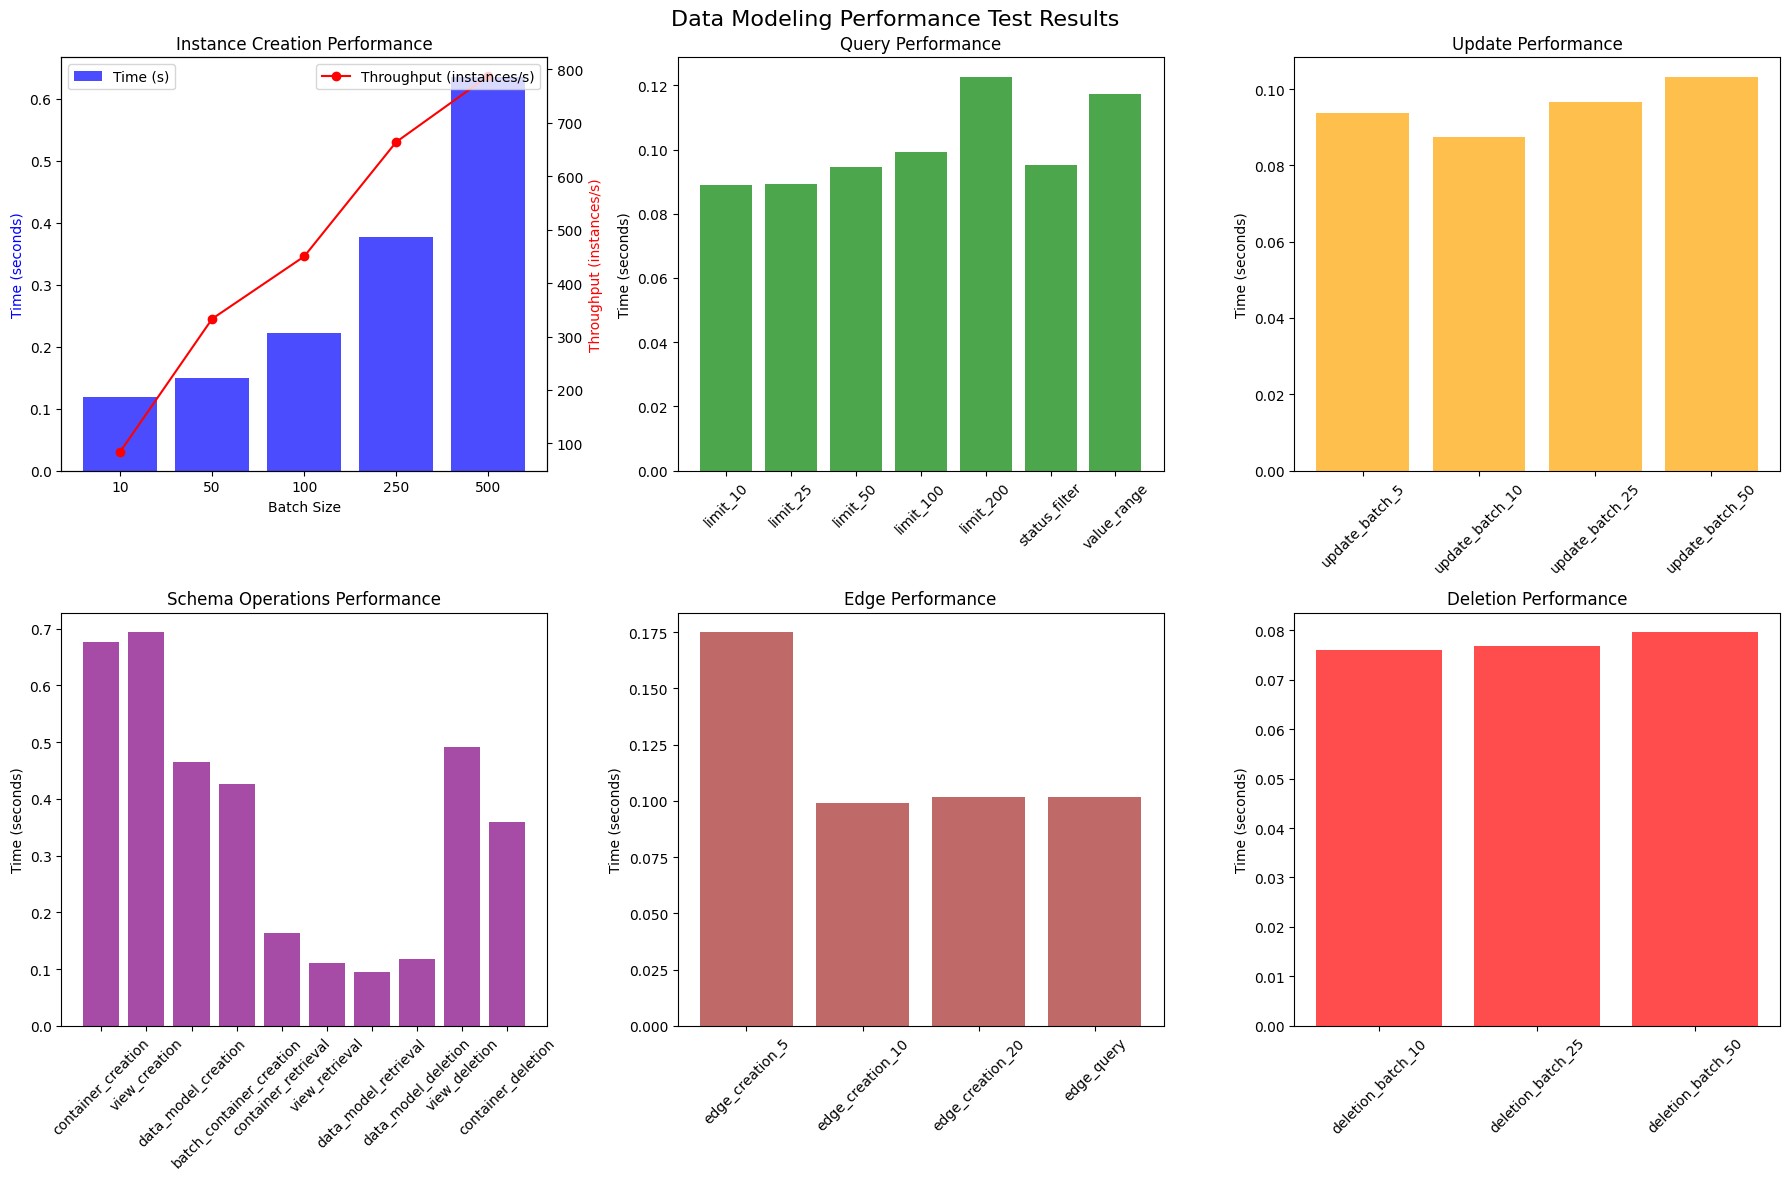

\n✅ Data modeling performance testing complete!
📋 Test space: perf_test_space_1753691062
🏗️ Containers: 2
👁️ Views: 2
📊 Data model: PerfTestDataModel_1753691062
💾 Results can be saved using the PerformanceTracker.save_results() method


In [12]:
# Performance Results Summary and Visualization
def summarize_and_visualize_results():
    """Summarize all data modeling performance test results and create visualizations."""
    
    if not test_space:
        print("❌ No test results to summarize - test space not available.")
        return
    
    print("📈 Data Modeling Performance Test Results Summary")
    print("=" * 60)
    
    # Summarize each test
    if 'creation_results' in globals() and creation_results:
        print("\\n🏭 Instance Creation Performance:")
        for batch_size, results in creation_results.items():
            if results:
                throughput = batch_size / results['mean_time'] if results['mean_time'] > 0 else 0
                print(f"  Batch {batch_size:3d} | {results['mean_time']:.4f}s avg | {throughput:.2f} instances/s")
    
    if 'query_results' in globals() and query_results:
        print("\\n🔍 Instance Query Performance:")
        for test_name, results in query_results.items():
            if results:
                print(f"  {test_name:15} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'update_results' in globals() and update_results:
        print("\\n✏️ Instance Update Performance:")
        for test_name, results in update_results.items():
            if results:
                batch_size = int(test_name.split('_')[-1]) if 'batch' in test_name else 1
                throughput = batch_size / results['mean_time'] if results['mean_time'] > 0 else 0
                print(f"  {test_name:15} | {results['mean_time']:.4f}s avg | {throughput:.2f} updates/s")
    
    if 'edge_results' in globals() and edge_results:
        print("\\n🔗 Edge Performance:")
        for test_name, results in edge_results.items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if globals().get('schema_results'):
        print("\\n📋 Schema Operations Performance:")
        for test_name, results in globals().get('schema_results', {}).items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'deletion_results' in globals() and deletion_results:
        print("\\n🗑️ Instance Deletion Performance:")
        for test_name, results in deletion_results.items():
            if results:
                batch_size = int(test_name.split('_')[-1]) if 'batch' in test_name else 1
                throughput = batch_size / results['mean_time'] if results['mean_time'] > 0 else 0
                print(f"  {test_name:15} | {results['mean_time']:.4f}s avg | {throughput:.2f} deletions/s")
    
    # Create visualization if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Data Modeling Performance Test Results', fontsize=16)
        
        # Plot 1: Instance Creation Performance
        if 'creation_results' in globals() and creation_results:
            ax = axes[0, 0]
            batch_sizes = [size for size, results in creation_results.items() if results]
            times = [creation_results[size]['mean_time'] for size in batch_sizes]
            throughputs = [size / creation_results[size]['mean_time'] for size in batch_sizes]
            
            ax2 = ax.twinx()
            ax.bar([str(size) for size in batch_sizes], times, alpha=0.7, color='blue', label='Time (s)')
            ax2.plot([str(size) for size in batch_sizes], throughputs, 'ro-', label='Throughput (instances/s)')
            
            ax.set_title('Instance Creation Performance')
            ax.set_xlabel('Batch Size')
            ax.set_ylabel('Time (seconds)', color='blue')
            ax2.set_ylabel('Throughput (instances/s)', color='red')
            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')
        
        # Plot 2: Query Performance
        if 'query_results' in globals() and query_results:
            ax = axes[0, 1]
            query_tests = [name for name, results in query_results.items() if results]
            query_times = [query_results[name]['mean_time'] for name in query_tests]
            
            ax.bar(query_tests, query_times, color='green', alpha=0.7)
            ax.set_title('Query Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 3: Update Performance
        if 'update_results' in globals() and update_results:
            ax = axes[0, 2]
            update_tests = [name for name, results in update_results.items() if results]
            update_times = [update_results[name]['mean_time'] for name in update_tests]
            
            ax.bar(update_tests, update_times, color='orange', alpha=0.7)
            ax.set_title('Update Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 4: Schema Operations
        if globals().get('schema_results'):
            ax = axes[1, 0]
            schema_results = globals().get('schema_results', {})
            schema_tests = [name for name, results in schema_results.items() if results]
            schema_times = [schema_results[name]['mean_time'] for name in schema_tests]
            
            ax.bar(schema_tests, schema_times, color='purple', alpha=0.7)
            ax.set_title('Schema Operations Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 5: Edge Performance
        if 'edge_results' in globals() and edge_results:
            ax = axes[1, 1]
            edge_tests = [name for name, results in edge_results.items() if results]
            edge_times = [edge_results[name]['mean_time'] for name in edge_tests]
            
            ax.bar(edge_tests, edge_times, color='brown', alpha=0.7)
            ax.set_title('Edge Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        # Plot 6: Deletion Performance
        if 'deletion_results' in globals() and deletion_results:
            ax = axes[1, 2]
            deletion_tests = [name for name, results in deletion_results.items() if results]
            deletion_times = [deletion_results[name]['mean_time'] for name in deletion_tests]
            
            ax.bar(deletion_tests, deletion_times, color='red', alpha=0.7)
            ax.set_title('Deletion Performance')
            ax.set_ylabel('Time (seconds)')
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("\\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\\n✅ Data modeling performance testing complete!")
    print(f"📋 Test space: {test_space}")
    print(f"🏗️ Containers: {len(test_containers)}")
    print(f"👁️ Views: {len(test_views)}")
    print(f"📊 Data model: {test_data_model}")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_results()

In [13]:
# 🧹 COMPREHENSIVE DATA MODELING CLEANUP 
# =======================================



# IMPROVED CLEANUP FUNCTION WITH PROPER VERSION HANDLING
def improved_cleanup_data_modeling_objects(space_id, created_objects=None):
    """
    Enhanced cleanup function for data modeling objects with proper version handling.
    
    Args:
        space_id: The space containing the objects to clean up
        created_objects: Dict with lists of created objects (optional)
    """
    
    if not client:
        print("❌ Cannot cleanup: CDF client not available")
        return
    
    print(f"🧹 Starting improved cleanup for space: {space_id}")
    
    cleanup_stats = {
        'data_models_deleted': 0,
        'views_deleted': 0,
        'containers_deleted': 0,
        'instances_deleted': 0,
        'edges_deleted': 0,
        'errors': []
    }
    
    try:
        # Step 1: Delete all instances first (if any)
        print("  1. Cleaning up instances...")
        try:
            # Query all instances in the space - handle both new and legacy API
            try:
                instance_results = client.data_modeling.instances.list(
                    sources=[],
                    space=space_id,
                    limit=1000
                )
            except:
                # Fallback to legacy method
                nodes = client.data_modeling.instances.list(instance_type="node", limit=1000)
                edges = client.data_modeling.instances.list(instance_type="edge", limit=1000)
                instance_results = list(nodes) + list(edges)
            
            if hasattr(instance_results, '__len__') and len(instance_results) > 0:
                print(f"    Found {len(instance_results)} instances to delete")
                
                # Handle both nodes and edges
                nodes_to_delete = []
                edges_to_delete = []
                
                for instance in instance_results:
                    if hasattr(instance, 'space') and instance.space == space_id:
                        if hasattr(instance, 'type'):  # Edge
                            edges_to_delete.append(instance.as_id())
                        else:  # Node
                            nodes_to_delete.append(instance.as_id())
                
                if nodes_to_delete:
                    client.data_modeling.instances.delete(nodes=nodes_to_delete)
                    cleanup_stats['instances_deleted'] += len(nodes_to_delete)
                    print(f"    ✅ Deleted {len(nodes_to_delete)} instances")
                
                if edges_to_delete:
                    client.data_modeling.instances.delete(edges=edges_to_delete)
                    cleanup_stats['edges_deleted'] += len(edges_to_delete)
                    print(f"    ✅ Deleted {len(edges_to_delete)} edges")
                
        except Exception as e:
            print(f"    ⚠️ Warning during instance cleanup: {e}")
            cleanup_stats['errors'].append(f"Instance cleanup: {e}")
        
        # Step 2: Delete data models with explicit version handling
        print("  2. Cleaning up data models...")
        try:
            data_models = client.data_modeling.data_models.list(space=space_id, limit=100)
            
            if data_models:
                print(f"    Found {len(data_models)} data models to delete")
                
                for dm in data_models:
                    try:
                        if hasattr(dm, 'version') and dm.version:
                            print(f"    Deleting data model: {dm.external_id} (v{dm.version})")
                            client.data_modeling.data_models.delete([dm.as_id()])
                            cleanup_stats['data_models_deleted'] += 1
                            print(f"    ✅ Deleted: {dm.external_id}")
                        else:
                            print(f"    ❌ Skipping {dm.external_id} - missing version")
                            
                    except Exception as dm_error:
                        print(f"    ⚠️ Failed to delete data model {dm.external_id}: {dm_error}")
                        cleanup_stats['errors'].append(f"Data model {dm.external_id}: {dm_error}")
            
        except Exception as e:
            print(f"    ⚠️ Error during data model cleanup: {e}")
            cleanup_stats['errors'].append(f"Data model cleanup: {e}")
        
        # Step 3: Delete views with version handling
        print("  3. Cleaning up views...")
        try:
            views = client.data_modeling.views.list(space=space_id, limit=100)
            
            if views:
                print(f"    Found {len(views)} views to delete")
                
                for view in views:
                    try:
                        print(f"    Deleting view: {view.external_id} (v{view.version})")
                        client.data_modeling.views.delete([view.as_id()])
                        cleanup_stats['views_deleted'] += 1
                        print(f"    ✅ Deleted: {view.external_id}")
                        
                    except Exception as view_error:
                        print(f"    ⚠️ Failed to delete view {view.external_id}: {view_error}")
                        cleanup_stats['errors'].append(f"View {view.external_id}: {view_error}")
                        
        except Exception as e:
            print(f"    ⚠️ Error during view cleanup: {e}")
            cleanup_stats['errors'].append(f"View cleanup: {e}")
        
        # Step 4: Delete containers
        print("  4. Cleaning up containers...")
        try:
            containers = client.data_modeling.containers.list(space=space_id, limit=100)
            
            if containers:
                print(f"    Found {len(containers)} containers to delete")
                
                for container in containers:
                    try:
                        print(f"    Deleting container: {container.external_id}")
                        client.data_modeling.containers.delete([container.as_id()])
                        cleanup_stats['containers_deleted'] += 1
                        print(f"    ✅ Deleted: {container.external_id}")
                        
                    except Exception as container_error:
                        print(f"    ⚠️ Failed to delete container {container.external_id}: {container_error}")
                        cleanup_stats['errors'].append(f"Container {container.external_id}: {container_error}")
                        
        except Exception as e:
            print(f"    ⚠️ Error during container cleanup: {e}")
            cleanup_stats['errors'].append(f"Container cleanup: {e}")
        
        # Step 5: Delete test space if applicable
        if "test" in space_id.lower() or "perf" in space_id.lower():
            print("  5. Attempting to delete test space...")
            try:
                client.data_modeling.spaces.delete([space_id])
                print(f"    ✅ Successfully deleted space: {space_id}")
            except Exception as e:
                print(f"    ⚠️ Could not delete space {space_id}: {e}")
                cleanup_stats['errors'].append(f"Space deletion: {e}")
        else:
            print("  5. Skipping space deletion (not a test space)")
        
    except Exception as e:
        print(f"❌ Unexpected error during cleanup: {e}")
        cleanup_stats['errors'].append(f"General cleanup: {e}")
    
    # Print summary
    print("\n📊 Cleanup Summary:")
    print(f"  Data models deleted: {cleanup_stats['data_models_deleted']}")
    print(f"  Views deleted: {cleanup_stats['views_deleted']}")  
    print(f"  Containers deleted: {cleanup_stats['containers_deleted']}")
    print(f"  Instances deleted: {cleanup_stats['instances_deleted']}")
    print(f"  Edges deleted: {cleanup_stats['edges_deleted']}")
    
    if cleanup_stats['errors']:
        print(f"\n⚠️ Errors encountered: {len(cleanup_stats['errors'])}")
        for error in cleanup_stats['errors'][:3]:  # Show first 3 errors
            print(f"    - {error}")
        if len(cleanup_stats['errors']) > 3:
            print(f"    ... and {len(cleanup_stats['errors']) - 3} more errors")
    else:
        print("\n✅ Cleanup completed without errors!")
    
    return cleanup_stats


# LEGACY CLEANUP FUNCTION (For backward compatibility)
def cleanup_test_data_model(space_id, container_ids=None, view_ids=None, data_model_id=None):
    """Legacy cleanup function - now uses improved cleanup internally."""
    print("🔄 Using improved cleanup function...")
    return improved_cleanup_data_modeling_objects(space_id)


print("\n🚀 CLEANUP USAGE:")
print("=" * 30)
print("# Cleanup current test space:")
print("improved_cleanup_data_modeling_objects(test_space)")
print("")
print("# Cleanup specific space:")  
print("improved_cleanup_data_modeling_objects('perf_test_space_12345')")
print("")
print("# Legacy function (redirects to improved cleanup):")
print("cleanup_test_data_model(test_space)")

# AUTOMATIC CLEANUP OF CURRENT TEST SPACE (uncomment to run)
improved_cleanup_data_modeling_objects(test_space)

print("\n🎯 Data Modeling Performance Testing Tips:")
print("- Data modeling operations are generally slower than time series operations")
print("- Schema operations (containers, views) are heavier than instance operations")
print("- Consider the complexity of your data model when planning performance")
print("- Use appropriate batch sizes for your use case")
print("- Monitor your CDF quota usage during testing")
print("- Test with realistic data volumes and complexity")

print("\n📝 Next Steps:")
print("- Analyze performance patterns for your specific use case")
print("- Compare different data modeling approaches")
print("- Test with production-like data complexity")
print("- Consider indexing strategies for frequently queried properties")
print("- Plan for data model evolution and migration scenarios")

print("\n⚠️ Important Notes:")
print("- Always cleanup test data to avoid cluttering your CDF project")
print("- Be aware of CDF limits and quotas when running large-scale tests")
print("- Consider running tests in a dedicated test project")
print("- Data modeling operations can be resource-intensive")



🚀 CLEANUP USAGE:
# Cleanup current test space:
improved_cleanup_data_modeling_objects(test_space)

# Cleanup specific space:
improved_cleanup_data_modeling_objects('perf_test_space_12345')

# Legacy function (redirects to improved cleanup):
cleanup_test_data_model(test_space)
🧹 Starting improved cleanup for space: perf_test_space_1753691062
  1. Cleaning up instances...
    Found 1000 instances to delete
    ✅ Deleted 1000 edges
  2. Cleaning up data models...
    Found 1 data models to delete
    Deleting data model: PerfTestDataModel_1753691062 (v1)
    ✅ Deleted: PerfTestDataModel_1753691062
  3. Cleaning up views...
    Found 2 views to delete
    Deleting view: AssetView (v1)
    ✅ Deleted: AssetView
    Deleting view: EquipmentView (v1)
    ✅ Deleted: EquipmentView
  4. Cleaning up containers...
    Found 2 containers to delete
    Deleting container: AssetContainer
    ✅ Deleted: AssetContainer
    Deleting container: EquipmentContainer
    ✅ Deleted: EquipmentContainer
  5. At